# Task 2 Clustering
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to cluster the data

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from prettytable import PrettyTable
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

In [13]:
df = pd.read_csv("../dataset/user_indicators.csv")
df.head(10)

,user_id,lang,bot,created_at,statuses_count,tweet_count,avg_text_len,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_sum,favorite_count_sum
0,2353593986,en,True,2019-02-22 18:00:42,76,127,62.378788,0.037879,0.000000,0.037879,0.098485,0.000000,0.272727,5,5
1,2358850842,en,False,2019-02-26 03:02:32,54,119,68.762295,0.024590,0.000000,0.049180,0.024590,0.000000,0.336066,3,6
2,137959629,en,True,2015-04-30 07:09:56,3,4,19.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,466124818,it,True,2017-01-18 02:49:18,50,1394,86.763030,0.826963,0.000000,0.166782,0.073662,0.022238,0.006254,1190,240
4,2571493866,en,False,2019-06-18 19:30:21,7085,3535,72.214442,0.016958,0.000000,0.056072,0.117888,0.000821,0.505470,62,205
5,2199062688,en,False,2018-11-19 06:58:18,7406,1989,45.100913,393.697261,0.000000,0.735704,0.024027,0.022585,0.928400,819284,1531
6,1174869769,en,True,2018-02-15 10:51:28,21,24,64.041667,630.166667,0.000000,94.666667,0.458333,0.125000,0.125000,15124,2272
7,3118659848,en,False,2020-03-31 21:19:59,115,130,62.400000,3090.303704,0.000000,0.925926,0.111111,0.088889,0.807407,417191,125
8,616225564,en,False,2017-06-25 15:49:36,2041,58,66.883333,69.850000,0.016667,0.050000,0.233333,0.033333,0.016667,4191,3
9,2357425536,en,True,2019-02-25 04:30:56,69,144,64.286667,0.040000,0.000000,0.033333,0.100000,0.000000,0.340000,6,5


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             11508 non-null  int64  
 1   lang                11508 non-null  object 
 2   bot                 11508 non-null  bool   
 3   created_at          11508 non-null  object 
 4   statuses_count      11508 non-null  int64  
 5   tweet_count         11508 non-null  int64  
 6   avg_text_len        11508 non-null  float64
 7   retweet_count_avg   11508 non-null  float64
 8   reply_count_avg     11508 non-null  float64
 9   favorite_count_avg  11508 non-null  float64
 10  num_hashtags_avg    11508 non-null  float64
 11  num_urls_avg        11508 non-null  float64
 12  num_mentions_avg    11508 non-null  float64
 13  retweet_count_sum   11508 non-null  int64  
 14  favorite_count_sum  11508 non-null  int64  
dtypes: bool(1), float64(7), int64(5), object(2)
memory us

In [15]:
cat_feature = df[['user_id', 'lang', 'created_at']]
del df['user_id']
del df['lang']
del df['created_at']
del df['bot']
df.head()

,statuses_count,tweet_count,avg_text_len,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_sum,favorite_count_sum
0,76,127,62.378788,0.037879,0.0,0.037879,0.098485,0.000000,0.272727,5,5
1,54,119,68.762295,0.024590,0.0,0.049180,0.024590,0.000000,0.336066,3,6
2,3,4,19.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0
3,50,1394,86.763030,0.826963,0.0,0.166782,0.073662,0.022238,0.006254,1190,240
4,7085,3535,72.214442,0.016958,0.0,0.056072,0.117888,0.000821,0.505470,62,205


## Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max

In [16]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df.values)
X_std

array([[-0.30258956, -0.66364966, -0.34704183, ..., -0.2293346 ,
        -0.17600845, -0.07752062],
       [-0.30376279, -0.67015003,  0.04770931, ..., -0.05664378,
        -0.1760091 , -0.07748064],
       [-0.30648253, -0.76359287, -3.0140927 , ..., -0.97292096,
        -0.17601008, -0.07772051],
       ...,
       [-0.30632254, -0.76115523,  0.25676065, ...,  0.19557188,
        -0.17601008, -0.07772051],
       [-0.30440273, -0.68477587, -0.32452807, ...,  0.01380633,
        -0.17600779, -0.07740068],
       [-0.0251226 ,  2.11607153, -0.98720074, ...,  1.19040404,
         0.48220648, -0.06028945]])

In [17]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(df.values)
X_minmax

array([[1.90211610e-04, 3.21510589e-02, 2.45366892e-01, ...,
        4.64618484e-02, 4.96593715e-08, 5.40565085e-06],
       [1.35150355e-04, 3.01097219e-02, 2.71745021e-01, ...,
        5.72521684e-02, 2.97956229e-08, 6.48678102e-06],
       [7.50835304e-06, 7.65501403e-04, 6.71487603e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.50167061e-05, 1.53100281e-03, 2.85714286e-01, ...,
        7.30114761e-02, 0.00000000e+00, 0.00000000e+00],
       [1.05116943e-04, 2.55167134e-02, 2.46871311e-01, ...,
        6.16541353e-02, 6.95231201e-08, 8.64904136e-06],
       [1.32121986e-02, 9.05077826e-01, 2.02590084e-01, ...,
        1.35172032e-01, 2.00273564e-02, 4.71372754e-04]])

## K-MEANS

For K-Means we use

Best results without entropies obtained using **minmax scaler**

In [18]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):

        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [155]:
clusters_list = [x for x in range(1, 31)]
init_value = 10
iter_value = 300

kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)

sse_list = []
silhouette_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(X_minmax, kmeans.labels_)
    except:
        silhouette = np.nan # silhouette returns exception when there is only 1 label
    silhouette_list.append(silhouette)

    print('K:', clusters_list[i], ' - SSE:', kmeans.inertia_, '- SILHOUETTE:', silhouette)


100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


K: 1  - SSE: 1312.752078323833 - SILHOUETTE: nan
K: 2  - SSE: 380.2287416531721 - SILHOUETTE: 0.6768948380985009
K: 3  - SSE: 209.90064461705 - SILHOUETTE: 0.6637413641898913
K: 4  - SSE: 181.85807086068135 - SILHOUETTE: 0.6101451202072852
K: 5  - SSE: 162.52694235251315 - SILHOUETTE: 0.5675627072697336
K: 6  - SSE: 148.954546609747 - SILHOUETTE: 0.5576710415072987
K: 7  - SSE: 137.6085537455288 - SILHOUETTE: 0.5428087469110022
K: 8  - SSE: 128.11189374246928 - SILHOUETTE: 0.543983986385702
K: 9  - SSE: 119.58973856579314 - SILHOUETTE: 0.5467542777793295
K: 10  - SSE: 112.49964898255563 - SILHOUETTE: 0.5479540364047025
K: 11  - SSE: 106.25206505348257 - SILHOUETTE: 0.3602007826370423
K: 12  - SSE: 99.56349153241543 - SILHOUETTE: 0.3628890085265423
K: 13  - SSE: 94.47188391519128 - SILHOUETTE: 0.3691414775471183
K: 14  - SSE: 87.90742830369541 - SILHOUETTE: 0.37427297591201647
K: 15  - SSE: 83.81673392942612 - SILHOUETTE: 0.3792682502828559
K: 16  - SSE: 80.22986588496158 - SILHOUETTE: 

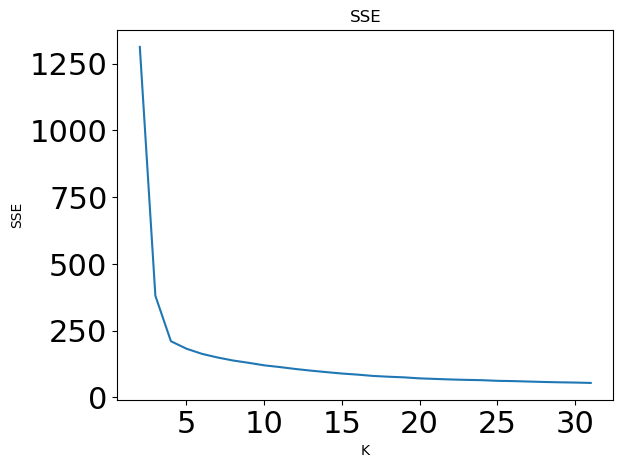

In [39]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.show()

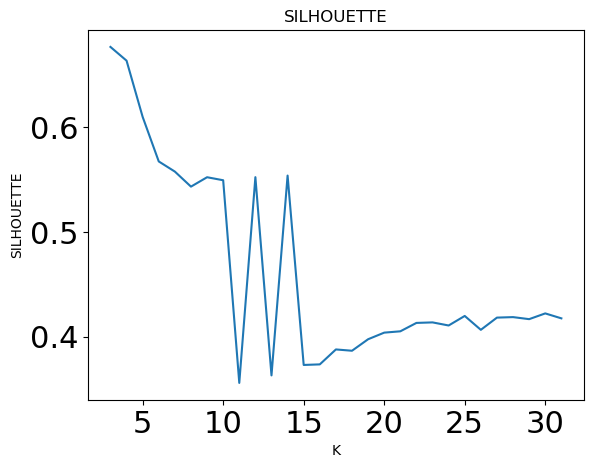

In [40]:
plt.plot(range(2, len(silhouette_list) + 2), silhouette_list)
plt.ylabel('SILHOUETTE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SILHOUETTE')
plt.show()

For K-Means, after analyizing SSE and Silhouette, we selected K=4, as it is approximately at the last significant SSE decrease in the SSE graph, while mantaining a relatively high Silhouette (Sihouette is high up to K=10 clusters). 

In [ ]:
final_kmeans = kmeans_list[3]

scatter con plot adeguato

distribuzioni plot per ogni cluster (utilizzando label bot)

# DBSCAN

Function that shows graph of knn diastance in in order to use Knee Method to estimate the best eps

In [53]:
def calc_k_nn_dist_graph(X):
    k_list = [3, 4, 5 , 6]

    dist = pdist(X, 'euclidean') #pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist

    for k in k_list:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=22)
        f = plt.figure()
        f.set_figwidth(4)
        f.set_figheight(1)
        plt.show()

In [22]:
def db_scan_function (X, eps_list, minpts_list, max_iter_value=300):
    dbscan_table = list()

    for i, eps in tqdm(enumerate(eps_list)):
        dbscan_table.append([]) 

        for minpts in tqdm(minpts_list, leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)
            dbscan_table[i].append(dbscan)
    
    return dbscan_table

DBSCAN with **minmax scaler**

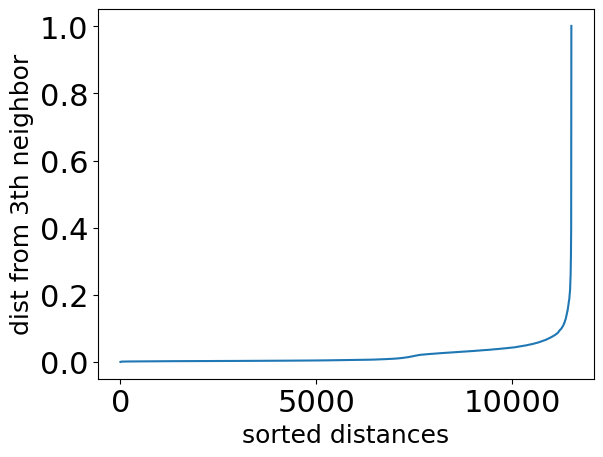

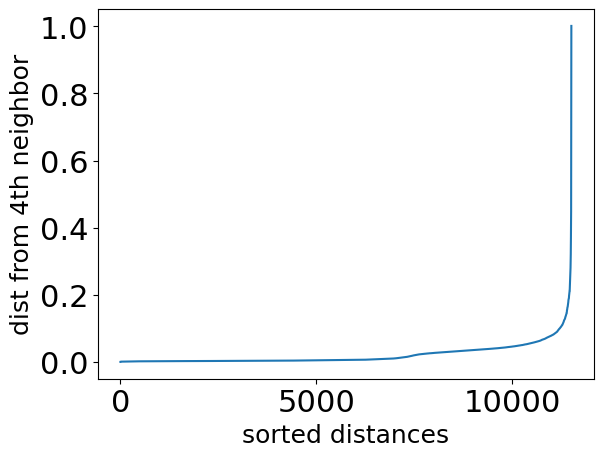

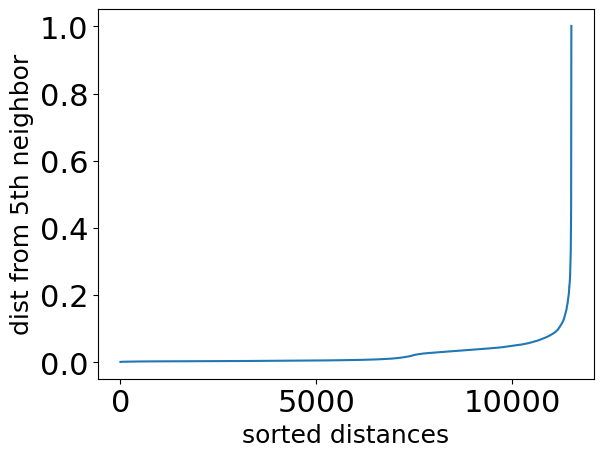

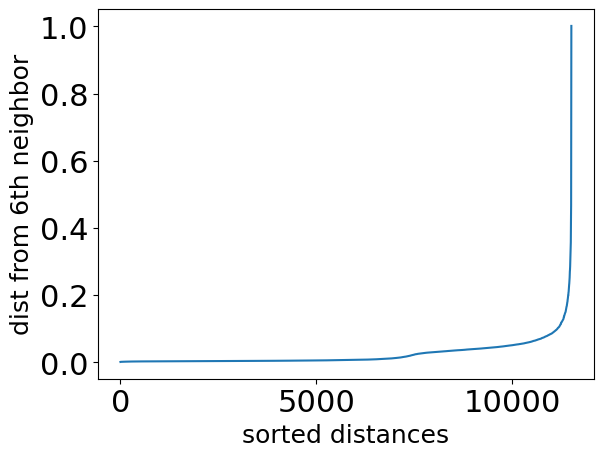

In [47]:
calc_k_nn_dist_graph(X_minmax)

We select values for eps around 0.08-0.2

In [48]:
eps_list = [0.08, 0.1, 0.15, 0.2] # min max vals
minpts_list = [2, 3, 4, 5] # min-max

dbscan_table = db_scan_function(X_minmax, eps_list, minpts_list)

4it [00:44, 11.21s/it]


In [49]:
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list

for i, eps in tqdm(enumerate(eps_list)):
    row_str = [str(eps)]
    for j, minpts  in tqdm(enumerate(minpts_list), leave=False):
        dbscan = dbscan_table[i][j]

        try:
            silhouette = round(silhouette_score(X_minmax, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)

    t.add_row(row_str)

print('MINMAX normalization \n')
print(t)

4it [01:30, 22.52s/it]

+------------+------------------+------------------+----------------+-----------------+
| eps\minpts |        2         |        3         |       4        |        5        |
+------------+------------------+------------------+----------------+-----------------+
|    0.08    | -0.34-n_clust:39 | -0.02-n_clust:14 | 0.0-n_clust:8  | -0.01-n_clust:3 |
|    0.1     | -0.32-n_clust:28 | 0.01-n_clust:10  | 0.15-n_clust:6 |  0.19-n_clust:5 |
|    0.15    | 0.04-n_clust:15  |  0.12-n_clust:7  | 0.41-n_clust:5 |  0.43-n_clust:3 |
|    0.2     |  0.35-n_clust:6  |  0.35-n_clust:5  | 0.58-n_clust:3 |  0.58-n_clust:3 |
+------------+------------------+------------------+----------------+-----------------+


DBSCAN with **standard scaler**

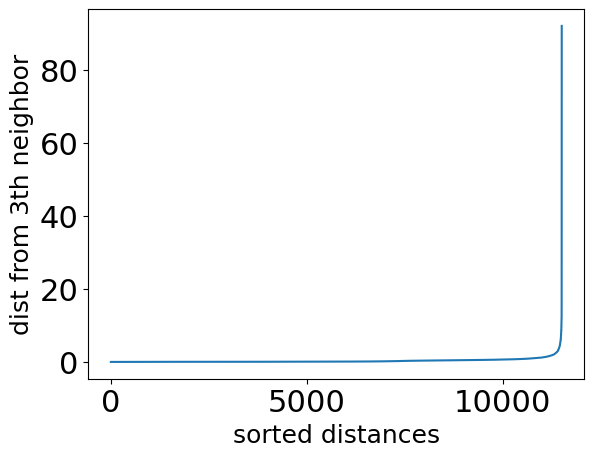

<Figure size 400x100 with 0 Axes>

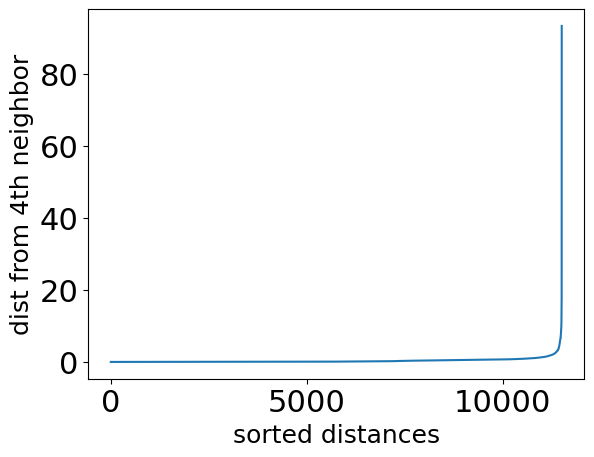

<Figure size 400x100 with 0 Axes>

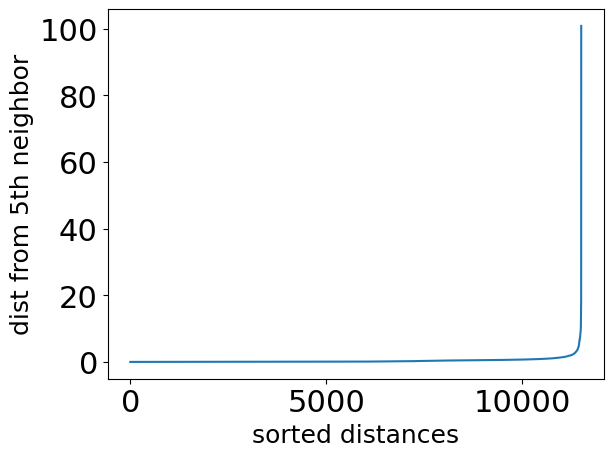

<Figure size 400x100 with 0 Axes>

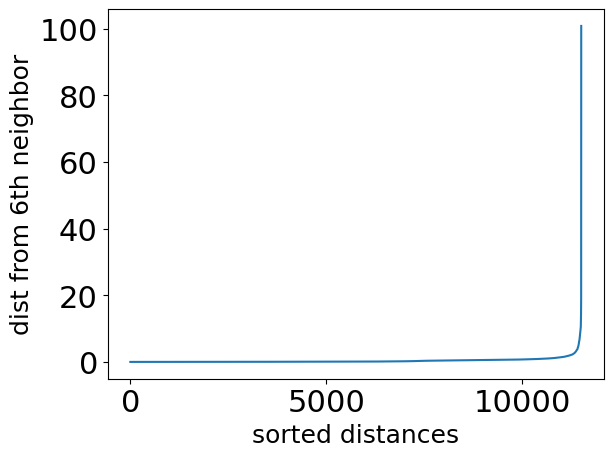

<Figure size 400x100 with 0 Axes>

In [55]:
calc_k_nn_dist_graph(X_std)

TODO: migliora grafico knn distances (cutoff a 20,  grid o yticks).
According to the Knee Method, we experimented with eps values in the range 1-3.

In [34]:
eps_list = [1, 1.25, 1.5, 2, 2.5, 3] 
minpts_list = [3, 4, 5, 6] 

dbscan_table = db_scan_function(X_std, eps_list, minpts_list)

6it [01:40, 16.82s/it]


In [35]:
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list


for i, eps in enumerate(eps_list):
    row_str = [str(eps)]
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table[i][j]

        try:
            silhouette = round(silhouette_score(X_std, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)
        #print('eps:', eps, 'minpts:', minpts ,' - Silhouette:', silhouette)
        #print('unique labels:', np.unique(dbscan.labels_))
    t.add_row(row_str)

print('STD normalization\n')
print(t)

+------------+-----------------+-----------------+----------------+----------------+
| eps\minpts |        3        |        4        |       5        |       6        |
+------------+-----------------+-----------------+----------------+----------------+
|     1      | 0.18-n_clust:18 | 0.21-n_clust:10 | 0.43-n_clust:4 | 0.55-n_clust:3 |
|    1.25    | 0.21-n_clust:16 |  0.26-n_clust:7 | 0.49-n_clust:3 | 0.55-n_clust:4 |
|    1.5     | 0.31-n_clust:10 |  0.32-n_clust:7 | 0.3-n_clust:2  | 0.56-n_clust:2 |
|     2      | 0.59-n_clust:10 |  0.59-n_clust:6 | 0.82-n_clust:1 | 0.81-n_clust:1 |
|    2.5     |  0.65-n_clust:8 |  0.7-n_clust:4  | 0.81-n_clust:3 | 0.84-n_clust:2 |
|     3      |  0.7-n_clust:7  |  0.7-n_clust:6  | 0.7-n_clust:5  | 0.71-n_clust:3 |
+------------+-----------------+-----------------+----------------+----------------+


After looking at the Silhouettes for both results tables of DBSCAN, we noted that std/mean normalization perform much better. 

Among the std/mean normalization results, we selected 2 clustering configurations for further analysis:
1.  eps: 2.5, minpts: 5, n_clusters: 3, Silhouette: 0.81
2.  eps: 3, minpts: 4, n_clusters: 6, Silhouette: 0.70

These 2 were selected because of their high Silhouette and because they have different number of clusters

In [ ]:
DBSCAN_final_3 = dbscan_table[4][2] # DBSCAn with 3 clusters
DBSCAN_final_6 = dbscan_table[5][1] # DBSCAn with 6 clusters

scatter con plot adeguato

distribuzioni plot per ogni cluster (utilizzando label bot)

# Hierarchical

After some preliminary trials we found that the best distance metric is **cosine**.

We also decided to discard "single" method, as it is sensitive to outliers and in our dataset we did not remove outliers based only on statistical methods.

Following we report the most significant dendograms of clusterings after having done a coarse selection of hierarchical clustering parameters after preliminary trials.

TODO: threshold selected on maximum length of dendogram branch

### With minmax normalization

In [135]:
config_hierarchical_minamx = []

Method: **complete**, threshold: 0.65, n_clusters: **8**

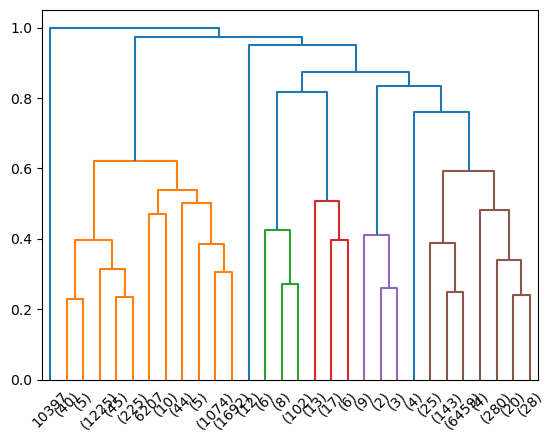

In [136]:
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=0.65, truncate_mode='lastp')
plt.show()
config_hierarchical_minamx.append((0.65, 'cosine', 'complete'))

Method: **ward**, threshold: 20, n_clusters: **2**

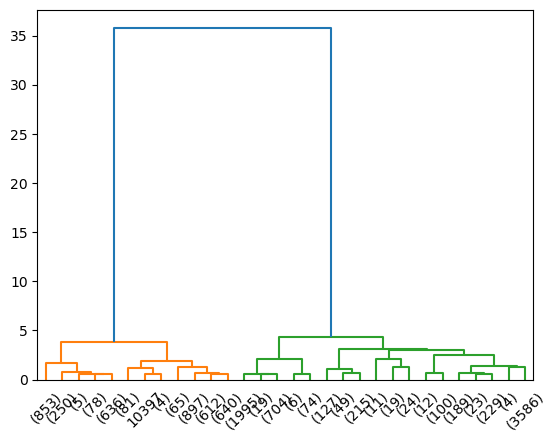

In [137]:
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=20, truncate_mode='lastp')
plt.show()
config_hierarchical_minamx.append((20, 'cosine', 'ward'))

In [138]:
cluster_list_minax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minamx:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
    cluster_list_minax.append(cluster)

In [150]:
for i, cluster in enumerate(cluster_list_minax):
    treshold, metric, method = config_hierarchical_minamx[i]

    try:
        silhouette = silhouette_score(X_minmax, cluster)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", len(np.unique(cluster)))

MINMAX - dist: cosine , method: complete , SILHOUTTE: 0.5037787642530678 , n_clusters: 8
MINMAX - dist: cosine , method: ward , SILHOUTTE: 0.6670339103765824 , n_clusters: 2


We selected the clustering with *method: ward** and *n_clusters: 2*, because of its high Shilouette and because the other clustering (*method: complete* and *n_clusters:8*) presents only 2 bigger clusters while the other ones are much smaller or even single-element clusters.

### With mean-std normalization

In [139]:
config_hierarchical_std = []

Method: **average**, threshold: 1.06, n_clusters: **3**

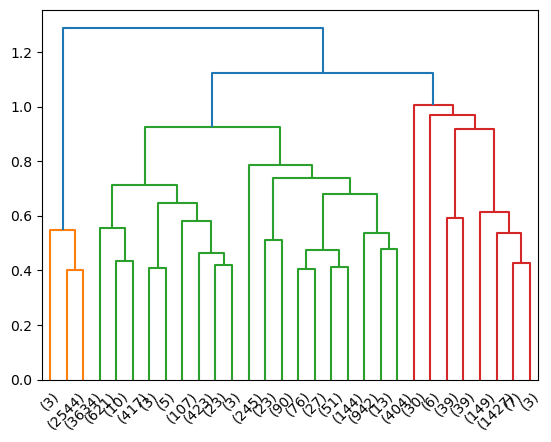

In [140]:
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=1.06, truncate_mode='lastp')
plt.show()
config_hierarchical_std.append((1.06, 'cosine', 'average'))

Method: **centroid**, threshold: 0.9, n_clusters: **3**

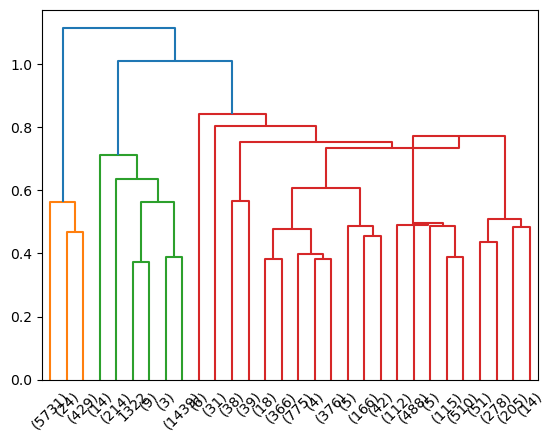

In [141]:
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.9, truncate_mode='lastp')
plt.show()
config_hierarchical_std.append((0.9, 'cosine', 'centroid'))

Method: **ward**, threshold: 35, n_clusters: **3**

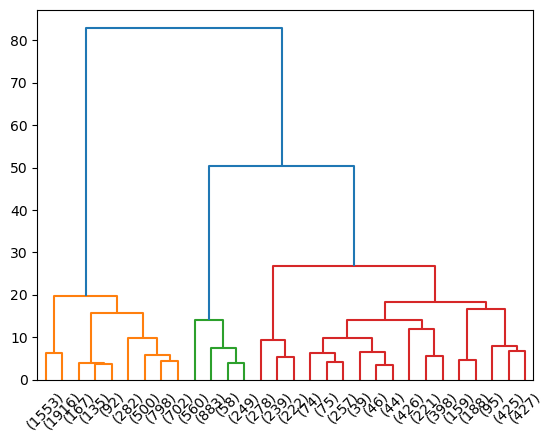

In [142]:
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=35, truncate_mode='lastp')
plt.show()
config_hierarchical_std.append((35, 'cosine', 'ward'))

In [143]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
    cluster_list_std.append(cluster)

In [151]:
print(len(cluster_list_std))
for i, cluster in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]

    try:
        silhouette = silhouette_score(X_std, cluster)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", len(np.unique(cluster)))

3
STD - dist: cosine , method: average , SILHOUTTE: 0.3624959621296031 , n_clusters: 3
STD - dist: cosine , method: centroid , SILHOUTTE: 0.33168999977685154 , n_clusters: 3
STD - dist: cosine , method: ward , SILHOUTTE: 0.3219765015117436 , n_clusters: 3


All 3 hierarchcal models have similar silhouette and same number of clusters, so we selected the clustering with *method: ward* because of the better cluster separation in the dendrogram.

Selcted for further analysis:
1.  STD normalization - dist: cosine, method: ward, n_clusters: 3, silhouette: 0.32
2.  MINMAX normalization - dist: cosine, method: ward, n_clusters: 2, silhouette: 0.67

In [ ]:
hierarchical_final_3 = cluster_list_std[2] # Hierarchical clustering with 3 clusters
hierarchical_final_2 = cluster_list_minax[1] # Hierarchical clustering with 2 clusters
# These clusters are only a list of labels, one for each point

TODO bot/non bot
(forse scatter)

TODO EXTRA: clusterizzazione bonus libreria esterna